In [1]:
import typing as t

In [2]:
class Elevator:
    def __init__(self, elevator_id: int, current_floor: int) -> None:
        self._elevator_id = elevator_id
        self._current_floor = current_floor

    def get_current_floor(self) -> int:
        return self._current_floor
    
    def up(self) -> None:
        self._current_floor += 1
        print(f'Лифт #{self._elevator_id} поднялся на этаж {self._current_floor}')
        
    def down(self) -> None:
        self._current_floor -= 1
        print(f'Лифт #{self._elevator_id} спустился на этаж {self._current_floor}')
        
    def __open_door(self) -> None:
        print(f'Лифт #{self._elevator_id} открыл дверь')
        
    def __close_door(self) -> None:
        print(f'Лифт #{self._elevator_id} закрыл дверь')
        
    def wait(self) -> None:
        self._inner_state = 2
        self.__open_door()
        self.__close_door()

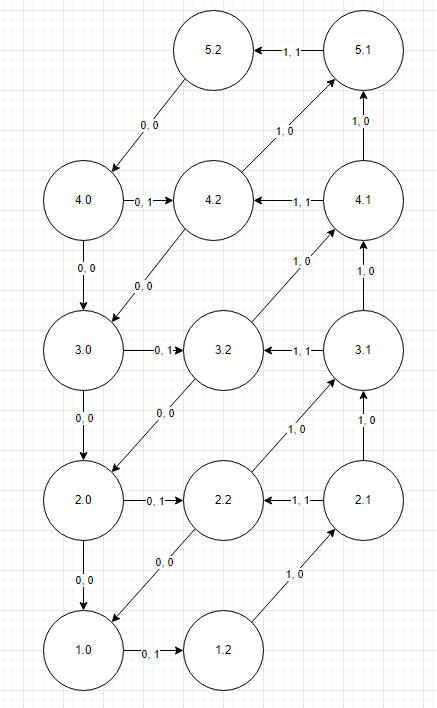
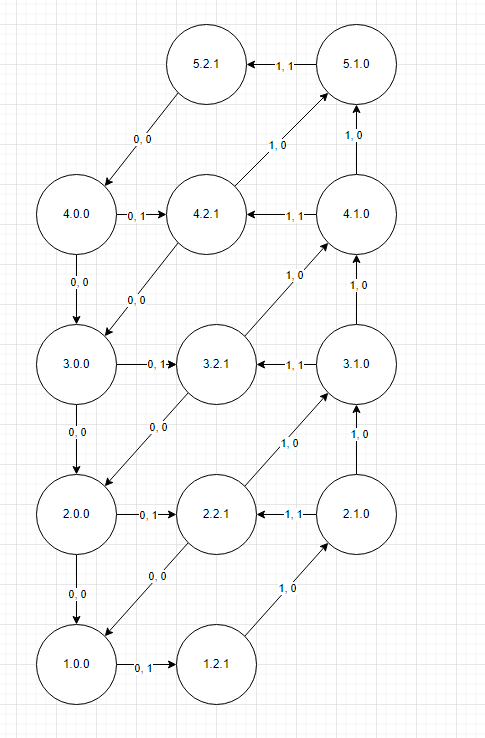

In [3]:
class ElevatorFSM:
    def __init__(self, n_floor: int, elevator: Elevator) -> None:
        self._fsm = self.__generate_fsm(n_floor)
        self._action_handler = self.__generate_action_handler(n_floor, elevator)
        self._elevator = elevator
        
    def __generate_fsm(self, n_floor) -> t.Dict[tuple, t.Dict[tuple, tuple]]:
        fsm = {
            (1, 2): {
                (1, 0): (2, 1),
            },
            (1, 0): {
                (0, 1): (1, 2)
            },
            (n_floor, 2): {
                (0, 0): (n_floor - 1, 0),
            },
            (n_floor, 1): {
                (1, 1): (n_floor, 2)
            }
        }

        for floor in range(2, n_floor):
            previous_floor = floor - 1
            next_floor = floor + 1
            fsm[(floor, 0)] = {
                (0, 0): (previous_floor, 0),
                (0, 1): (floor, 2),
            }
            fsm[(floor, 2)] = {
                (0, 0): (previous_floor, 0),
                (1, 0): (next_floor, 1),
            }
            fsm[(floor, 1)] = {
                (1, 0): (next_floor, 1),
                (1, 1): (floor, 2),
            }

        return fsm
    
    def __generate_action_handler(self, n_floor: int, elevator: Elevator) -> t.Dict[tuple, t.Dict[tuple, t.Callable]]:
        action_handler = {
            (1, 2): {
                (1, 0): elevator.up,
            },
            (1, 0): {
                (0, 1): elevator.wait
            },
            (n_floor, 2): {
                (0, 0): elevator.down,
            },
            (n_floor, 1): {
                (1, 1): elevator.wait
            }
        }

        for floor in range(2, n_floor):
            action_handler[(floor, 0)] = {
                (0, 0): elevator.down,
                (0, 1): elevator.wait,
            }
            action_handler[(floor, 2)] = {
                (0, 0): elevator.down,
                (1, 0): elevator.up,
            }
            action_handler[(floor, 1)] = {
                (1, 0): elevator.up,
                (1, 1): elevator.wait,
            }

        return action_handler
    
    def get_elevator(self) -> Elevator:
        return self._elevator
    
    def next(self, state: tuple, action: tuple) -> t.Tuple[tuple, t.Callable]:
        try:
            new_state, handler = self._fsm[state][action], self._action_handler[state][action]
            return new_state, handler
        except KeyError as e:
            raise BaseException('Неверно выбран номер этажа')
            

In [4]:
class ElevatorController:
    def __init__(self, elevators: list[Elevator], n_floor: int) -> None:
        self._elevators_fsm = list(map(lambda elevator: ElevatorFSM(n_floor, elevator), elevators))
        self._n_floor = n_floor
        
    def __go_to(self, elevator_fsm: ElevatorFSM, start_state: tuple, direction: int, require_floor: int) -> None:
        elevator = elevator_fsm.get_elevator()
        is_final = elevator.get_current_floor() == require_floor
        is_wait = False

        while not (is_final and is_wait):
            action = (direction, is_final)
            start_state, handler = elevator_fsm.next(start_state, action)
            handler()

            is_final = elevator.get_current_floor() == require_floor
            is_wait = start_state[-1] == 2
        
        
    def __call__(self, current_floor: int, direction: int, next_floor: int) -> None:
        nearest_elevator = min(
            self._elevators_fsm, 
            key=lambda elevator_fsm: abs(current_floor - elevator_fsm.get_elevator().get_current_floor())
        )
        
        self.__go_to(
            nearest_elevator, (
                nearest_elevator.get_elevator().get_current_floor(), 2
            ), 
            current_floor - nearest_elevator.get_elevator().get_current_floor() >= 0, 
            current_floor
        )
        
        self.__go_to(
            nearest_elevator, (current_floor, 2), 
            direction, 
            next_floor
        )   
        

In [5]:
elevator_1 = Elevator(elevator_id=1, current_floor=3)
elevator_2 = Elevator(elevator_id=2, current_floor=2)

In [6]:
controller = ElevatorController(elevators=[elevator_1, elevator_2], n_floor=9)

In [7]:
controller(current_floor=8, direction=0, next_floor=1)

Лифт #1 поднялся на этаж 4
Лифт #1 поднялся на этаж 5
Лифт #1 поднялся на этаж 6
Лифт #1 поднялся на этаж 7
Лифт #1 поднялся на этаж 8
Лифт #1 открыл дверь
Лифт #1 закрыл дверь
Лифт #1 спустился на этаж 7
Лифт #1 спустился на этаж 6
Лифт #1 спустился на этаж 5
Лифт #1 спустился на этаж 4
Лифт #1 спустился на этаж 3
Лифт #1 спустился на этаж 2
Лифт #1 спустился на этаж 1
Лифт #1 открыл дверь
Лифт #1 закрыл дверь
